In [1]:
#(b)
from math import sqrt
import numpy as np
import pandas as pd
import rdflib
from rdflib import Graph
import networkx as nx
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from spektral.layers import GCNConv
from sklearn.metrics import roc_curve, auc

In [2]:
# Load RDF data into an RDFLib Graph
g = Graph()
g.parse("Graph.ttl", format="ttl") 

<Graph identifier=N8cf4ae4c479045ec8dd7d515f383139b (<class 'rdflib.graph.Graph'>)>

In [3]:
# Prepare lists to store subjects, predicates, and objects
subjects, predicates, objects = [], [], []

# Iterate over triples in the graph and append to lists
for subj, pred, obj in g:
    subjects.append(str(subj))
    predicates.append(str(pred))
    objects.append(str(obj))

# Create a DataFrame
rdf_df = pd.DataFrame({
    'Subject': subjects,
    'Predicate': predicates,
    'Object': objects
})

print(rdf_df)
rdf_df.to_csv('rdf_data.csv', index=False)

                                    Subject  \
0      https://w3id.org/def/foo#5667SAT1442   
1      https://w3id.org/def/foo#5619SAT1442   
2      https://w3id.org/def/foo#2107SAT1442   
3       https://w3id.org/def/foo#290SAT1442   
4      https://w3id.org/def/foo#6140SAT1442   
...                                     ...   
37467  https://w3id.org/def/foo#7790SAT1442   
37468  https://w3id.org/def/foo#1644SAT1442   
37469  https://w3id.org/def/foo#4466SAT1442   
37470   https://w3id.org/def/foo#422SAT1442   
37471  https://w3id.org/def/foo#8869SAT1442   

                                             Predicate  \
0             https://w3.org/2003/01/geo/wgs84_pos#lat   
1            https://w3.org/2003/01/geo/wgs84_pos#long   
2      http://www.w3.org/1999/02/22-rdf-syntax-ns#type   
3             https://w3.org/2003/01/geo/wgs84_pos#lat   
4                    https://w3id.org/def/foo#poaching   
...                                                ...   
37467  http://www.w3.org/1999

In [4]:
# Encoding
subjects, predicates, objects = set(), set(), set()
for subj, pred, obj in g:
    subjects.add(str(subj))
    predicates.add(str(pred))
    objects.add(str(obj))

# Create dictionaries for encoding
subject_dict = {subj: i for i, subj in enumerate(subjects)}
predicate_dict = {pred: i for i, pred in enumerate(predicates)}
object_dict = {obj: i for i, obj in enumerate(objects)}

# Prepare input tensors
subject_tensor, predicate_tensor, object_tensor = [], [], []
for subj, pred, obj in g:
    subject_tensor.append(subject_dict[str(subj)])
    predicate_tensor.append(predicate_dict[str(pred)])
    object_tensor.append(object_dict[str(obj)])

subject_tensor = np.array(subject_tensor)
predicate_tensor = np.array(predicate_tensor)
object_tensor = np.array(object_tensor)

# Train-test split
X = np.column_stack((subject_tensor, predicate_tensor, object_tensor))
y = np.ones(len(subject_tensor))  # Labels, if you have a classification task
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
object_tensor

array([ 9856,  9544,  7717, ...,  4690, 10924,  6938])

In [6]:
# Define the Graph Neural Network Model
class GraphNetwork(tf.keras.Model):
    def __init__(self, num_nodes, num_relations, embedding_dim):
        super(GraphNetwork, self).__init__()
        self.node_embedding = tf.keras.layers.Embedding(num_nodes, embedding_dim)
        self.relation_embedding = tf.keras.layers.Embedding(num_relations, embedding_dim)
        self.graph_convolution = tf.keras.layers.GlobalAveragePooling1D()
        self.dense_layer = tf.keras.layers.Dense(1, activation="sigmoid")

    def call(self, inputs):
        subject_embedding = self.node_embedding(inputs[0])
        predicate_embedding = self.relation_embedding(inputs[1])
        object_embedding = self.node_embedding(inputs[2])
        concatenated_features = tf.concat([subject_embedding, predicate_embedding, object_embedding], axis=-1)
        reshaped_features = tf.reshape(concatenated_features, shape=(-1, 1, concatenated_features.shape[-1]))
        graph_embedding = self.graph_convolution(reshaped_features)
        output = self.dense_layer(graph_embedding)
        return output

# Instantiate and compile the model
num_nodes = len(subject_dict)
num_relations = len(predicate_dict)
embedding_dim = 64
model = GraphNetwork(num_nodes, num_relations, embedding_dim)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


In [7]:
max_subject_index = max(subject_dict.values())
max_predicate_index = max(predicate_dict.values())
max_object_index = max(object_dict.values())

In [8]:
num_nodes = max(max_subject_index, max_object_index) + 1
num_relations = max_predicate_index + 1

In [9]:
model = GraphNetwork(num_nodes, num_relations, embedding_dim)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# Train the model
history = model.fit(
    [X_train[:, 0], X_train[:, 1], X_train[:, 2]], y_train,
    epochs=300,
    batch_size=32,
    validation_data=([X_test[:, 0], X_test[:, 1], X_test[:, 2]], y_test))

Epoch 1/300


937/937 [==============================] - 9s 8ms/step - loss: 0.0628 - accuracy: 0.9970 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 2/300
937/937 [==============================] - 9s 10ms/step - loss: 4.7767e-04 - accuracy: 1.0000 - val_loss: 2.5228e-04 - val_accuracy: 1.0000
Epoch 3/300
937/937 [==============================] - 8s 8ms/step - loss: 1.4436e-04 - accuracy: 1.0000 - val_loss: 9.9616e-05 - val_accuracy: 1.0000
Epoch 4/300
937/937 [==============================] - 8s 8ms/step - loss: 6.1200e-05 - accuracy: 1.0000 - val_loss: 4.7421e-05 - val_accuracy: 1.0000
Epoch 5/300
937/937 [==============================] - 8s 8ms/step - loss: 3.0149e-05 - accuracy: 1.0000 - val_loss: 2.4773e-05 - val_accuracy: 1.0000
Epoch 6/300
937/937 [==============================] - 8s 8ms/step - loss: 1.6016e-05 - accuracy: 1.0000 - val_loss: 1.3623e-05 - val_accuracy: 1.0000
Epoch 7/300
937/937 [==============================] - 8s 8ms/step - loss: 8.8779e-06 - accuracy: 1

937/937 [==============================] - 7s 8ms/step - loss: 7.6047e-09 - accuracy: 1.0000 - val_loss: 9.1081e-09 - val_accuracy: 1.0000
Epoch 53/300
937/937 [==============================] - 7s 8ms/step - loss: 7.5315e-09 - accuracy: 1.0000 - val_loss: 9.0244e-09 - val_accuracy: 1.0000
Epoch 54/300
937/937 [==============================] - 7s 8ms/step - loss: 7.4484e-09 - accuracy: 1.0000 - val_loss: 8.9440e-09 - val_accuracy: 1.0000
Epoch 55/300
937/937 [==============================] - 7s 8ms/step - loss: 7.3754e-09 - accuracy: 1.0000 - val_loss: 8.8646e-09 - val_accuracy: 1.0000
Epoch 56/300
937/937 [==============================] - 7s 8ms/step - loss: 7.3160e-09 - accuracy: 1.0000 - val_loss: 8.7876e-09 - val_accuracy: 1.0000
Epoch 57/300
937/937 [==============================] - 7s 8ms/step - loss: 7.2487e-09 - accuracy: 1.0000 - val_loss: 8.7120e-09 - val_accuracy: 1.0000
Epoch 58/300
937/937 [==============================] - 8s 8ms/step - loss: 7.1846e-09 - accuracy: 1.

Epoch 106/300
937/937 [==============================] - 7s 8ms/step - loss: 5.2495e-09 - accuracy: 1.0000 - val_loss: 6.3911e-09 - val_accuracy: 1.0000
Epoch 107/300
937/937 [==============================] - 7s 8ms/step - loss: 5.2269e-09 - accuracy: 1.0000 - val_loss: 6.3593e-09 - val_accuracy: 1.0000
Epoch 108/300
937/937 [==============================] - 7s 7ms/step - loss: 5.1977e-09 - accuracy: 1.0000 - val_loss: 6.3287e-09 - val_accuracy: 1.0000
Epoch 109/300
937/937 [==============================] - 7s 8ms/step - loss: 5.1694e-09 - accuracy: 1.0000 - val_loss: 6.3000e-09 - val_accuracy: 1.0000
Epoch 110/300
937/937 [==============================] - 7s 8ms/step - loss: 5.1511e-09 - accuracy: 1.0000 - val_loss: 6.2734e-09 - val_accuracy: 1.0000
Epoch 111/300
937/937 [==============================] - 7s 8ms/step - loss: 5.1293e-09 - accuracy: 1.0000 - val_loss: 6.2457e-09 - val_accuracy: 1.0000
Epoch 112/300
937/937 [==============================] - 7s 8ms/step - loss: 5.101

937/937 [==============================] - 7s 7ms/step - loss: 4.0899e-09 - accuracy: 1.0000 - val_loss: 5.0235e-09 - val_accuracy: 1.0000
Epoch 213/300
937/937 [==============================] - 7s 8ms/step - loss: 4.0826e-09 - accuracy: 1.0000 - val_loss: 5.0170e-09 - val_accuracy: 1.0000
Epoch 214/300
937/937 [==============================] - 7s 7ms/step - loss: 4.0762e-09 - accuracy: 1.0000 - val_loss: 5.0105e-09 - val_accuracy: 1.0000
Epoch 215/300
937/937 [==============================] - 7s 7ms/step - loss: 4.0717e-09 - accuracy: 1.0000 - val_loss: 5.0040e-09 - val_accuracy: 1.0000
Epoch 216/300
937/937 [==============================] - 7s 8ms/step - loss: 4.0676e-09 - accuracy: 1.0000 - val_loss: 4.9976e-09 - val_accuracy: 1.0000
Epoch 217/300
937/937 [==============================] - 7s 8ms/step - loss: 4.0603e-09 - accuracy: 1.0000 - val_loss: 4.9911e-09 - val_accuracy: 1.0000
Epoch 218/300
937/937 [==============================] - 7s 7ms/step - loss: 4.0575e-09 - accura

In [27]:
X_train

array([[ 6741,     2,  6938],
       [ 6914,     0,    80],
       [ 7611,     0, 10648],
       ...,
       [  553,     4,  7717],
       [ 2451,     0,  8150],
       [ 1312,     0,  3207]])

In [28]:
y_train

array([1., 1., 1., ..., 1., 1., 1.])

In [29]:
X_test

array([[7263,    4, 7717],
       [7752,    3, 5548],
       [1528,    4, 7717],
       ...,
       [5122,    4, 7717],
       [8587,    4, 7717],
       [3052,    5, 1009]])

In [30]:
y_test

array([1., 1., 1., ..., 1., 1., 1.])

In [37]:
# Make predictions

predictions = model.predict([X_test[:, 0], X_test[:, 1], X_test[:, 2]])


# # Convert probabilities to binary predictions (threshold is 0.5 by default)
binary_predictions = (predictions > 0.5).astype(int)

# Calculate the Micro F1 Score
micro_f1 = f1_score(y_test, binary_predictions, average='macro')

micro_f1

235/235 [==============================] - 0s 1ms/step


1.0

In [32]:
# Assuming 'predictions' is your model's output and 'y_test' is the actual labels
# Flatten predictions if they are multidimensional
predictions_flat = predictions.flatten()

# Create a DataFrame
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions_flat
})

print(comparison_df)
comparison_df.to_csv('predictions_comparison.csv', index=False)

      Actual  Predicted
0        1.0        1.0
1        1.0        1.0
2        1.0        1.0
3        1.0        1.0
4        1.0        1.0
...      ...        ...
7490     1.0        1.0
7491     1.0        1.0
7492     1.0        1.0
7493     1.0        1.0
7494     1.0        1.0

[7495 rows x 2 columns]


In [35]:
from sklearn.metrics import confusion_matrix, f1_score

# Convert predictions to binary (if your model outputs probabilities)
binary_predictions = np.round(predictions).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, binary_predictions)
print("Confusion Matrix:\n", cm)

# F1 Score
f1 = f1_score(y_test, binary_predictions)
print("F1 Scre:", f1)


Confusion Matrix:
 [[7495]]
F1 Scre: 1.0


In [34]:
# Assuming model is your trained model, and X_train, y_train, X_test, y_test are your datasets

# Predictions on training and test data
train_predictions = model.predict([X_train[:, 0], X_train[:, 1], X_train[:, 2]])
test_predictions = model.predict([X_test[:, 0], X_test[:, 1], X_test[:, 2]])

# Calculate RMSE for training data
train_rmse = sqrt(mean_squared_error(y_train, train_predictions))

# Calculate RMSE for test data
test_rmse = sqrt(mean_squared_error(y_test, test_predictions))

print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


# Check for overfitting
if train_rmse < test_rmse:
    print("Model may be overfitting")
else:
    print("Model performance is consistent")

235/235 [==============================] - 0s 2ms/step
Training RMSE: 1.4194185636844869e-09
Test RMSE: 0.0
Model performance is consistent


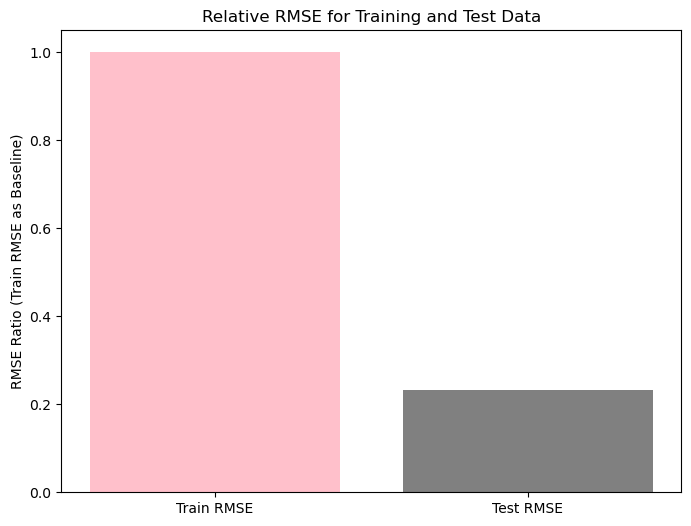

In [19]:
import matplotlib.pyplot as plt

# Assuming RMSE values are already calculated
train_rmse = 4.202223569526913e-09
test_rmse = 9.736643822349442e-10

# Convert RMSE to a ratio
# Here, I'm using train_rmse as the baseline, but you can adjust as needed
rmse_ratio = test_rmse / train_rmse

# Plotting the ratios
plt.figure(figsize=(8, 6))  # Adjust figure size if necessary
plt.bar(['Train RMSE', 'Test RMSE'], [1, rmse_ratio], color=['pink', 'grey'])
plt.ylabel('RMSE Ratio (Train RMSE as Baseline)')
plt.title('Relative RMSE for Training and Test Data')
plt.show()


In [20]:
inv_subject_dict = {v: k for k, v in subject_dict.items()}
inv_predicate_dict = {v: k for k, v in predicate_dict.items()}
inv_object_dict = {v: k for k, v in object_dict.items()}

In [21]:
rdf_predictions = []
for i in range(len(predictions)):
    subj = inv_subject_dict[X_test[i, 0]]
    pred = inv_predicate_dict[X_test[i, 1]]
    obj = inv_object_dict[X_test[i, 2]]
    rdf_predictions.append((subj, pred, obj))

In [22]:
rdf_predictions

[('https://w3id.org/def/foo#5008SAT1442',
  'http://www.w3.org/1999/02/22-rdf-syntax-ns#type',
  'http://w3.org/ns/sosa/Observation'),
 ('https://w3id.org/def/foo#Ribubonus',
  'https://w3id.org/def/foo#Tree_dbh_cm',
  '27.4'),
 ('https://w3id.org/def/foo#6124SAT1442',
  'http://www.w3.org/1999/02/22-rdf-syntax-ns#type',
  'http://w3.org/ns/sosa/Observation'),
 ('https://w3id.org/def/foo#8615SAT1442',
  'https://w3.org/2003/01/geo/wgs84_pos#long',
  '118.752716'),
 ('https://w3id.org/def/foo#2320SAT1442',
  'https://w3.org/2003/01/geo/wgs84_pos#long',
  '118.667564'),
 ('https://w3id.org/def/foo#8729SAT1442',
  'https://w3.org/2003/01/geo/wgs84_pos#lat',
  '5.0622'),
 ('https://w3id.org/def/foo#7666SAT1442',
  'https://w3.org/2003/01/geo/wgs84_pos#lat',
  '5.314417'),
 ('https://w3id.org/def/foo#3577SAT1442',
  'http://www.w3.org/1999/02/22-rdf-syntax-ns#type',
  'http://w3.org/ns/sosa/Observation'),
 ('https://w3id.org/def/foo#7124SAT1442',
  'http://www.w3.org/1999/02/22-rdf-syntax-n

In [23]:
# Assuming 'your_list' is the list you want to save
df = pd.DataFrame(rdf_predictions)

# Now you can use the to_csv method
df.to_csv('your_file.csv', index=False)

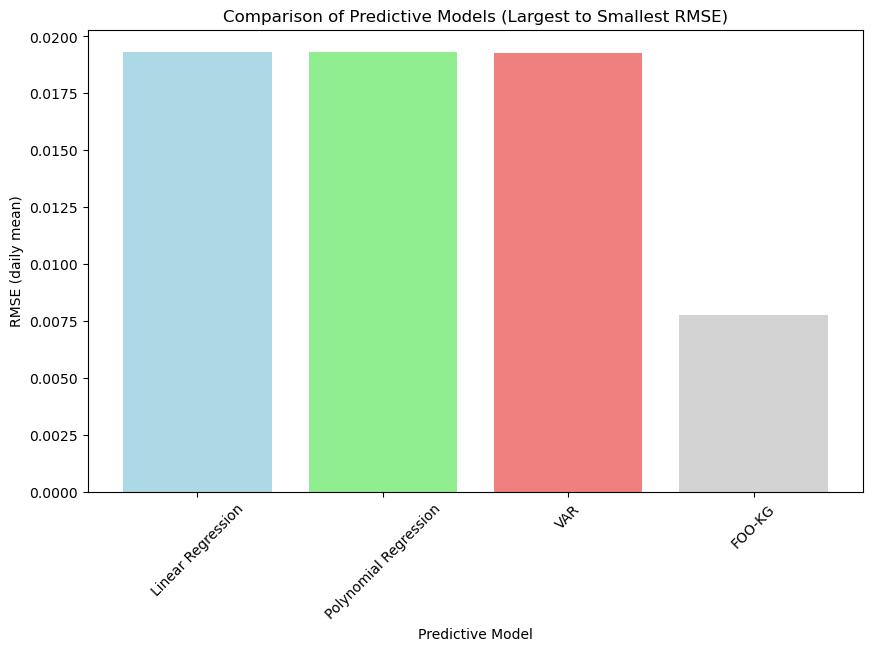

In [26]:
import matplotlib.pyplot as plt

# Data
models = ['Linear Regression', 'Polynomial Regression', 'VAR', 'FOO-KG']
rmse_values = [0.01933, 0.01932, 0.01927, 0.00775]

# Sorting the data by RMSE values in descending order
sorted_indices = sorted(range(len(rmse_values)), key=lambda i: rmse_values[i], reverse=True)
sorted_models = [models[i] for i in sorted_indices]
sorted_rmse_values = [rmse_values[i] for i in sorted_indices]

# Pastel colors
pastel_colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightgrey']

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(sorted_models, sorted_rmse_values, color=pastel_colors)
plt.xlabel('Predictive Model')
plt.ylabel('RMSE (daily mean)')
plt.title('Comparison of Predictive Models (Largest to Smallest RMSE)')
plt.xticks(rotation=45)
plt.show()